In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import segmentation_models_pytorch as smp
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "../Fourth_training_phase/CropAndWeed/ENB0+UNet_models/CropAndWeed_seg_standard_DiceLoss.pth" 
#output_folder = "Predictions_WE3DS"
#os.makedirs(output_folder, exist_ok=True)

In [3]:
model = smp.Unet(
    encoder_name="efficientnet-b0",
    encoder_weights="imagenet",
    in_channels=3,
    classes=101
)

In [4]:
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

/tmp/ipykernel_3096572/1481618732.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePadding

In [5]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),   # resizing
    transforms.ToTensor(),           # [0,1]
])

In [6]:
# --- Patch Extraction con log ---
def extract_patches(image, patch_size):
    w, h = image.size
    patches = []
    positions = []
    step = patch_size 

    print(f"[INFO] Dimensione immagine: {w}x{h}")
    print(f"[INFO] Patch size: {patch_size}, Step: {step}")

    x_coords = list(range(0, w, step))
    y_coords = list(range(0, h, step))

    print(f"[INFO] Numero patch in orizzontale: {len(x_coords)}")
    print(f"[INFO] Numero patch in verticale: {len(y_coords)}")
    print(f"[INFO] Numero totale di patch: {len(x_coords) * len(y_coords)}")

    for top in y_coords:
        for left in x_coords:
            right = min(left + patch_size, w)
            bottom = min(top + patch_size, h)
            patches.append(image.crop((left, top, right, bottom)))
            positions.append((left, top, right, bottom))
            print(f"   Patch: left={left}, top={top}, right={right}, bottom={bottom}")

    return patches, positions, (w, h)

In [7]:
# --- Patch Reconstruction ---
def reconstruct_mask(patch_masks, positions, full_size):
    W, H = full_size
    full_mask = np.zeros((H, W), dtype=np.int64)
    count = np.zeros((H, W), dtype=np.int32)

    for mask, (left, top, right, bottom) in zip(patch_masks, positions):
        h, w = mask.shape
        full_mask[top:bottom, left:right] += mask
        count[top:bottom, left:right] += 1

    full_mask = np.divide(full_mask, count)
    return full_mask.astype(np.int64)

In [8]:
class_colors = [
    (0, 0, 0), (255, 0, 0), (234, 0, 0), (212, 0, 0), (191, 0, 0), (170, 0, 0), (149, 0, 0),
    (255, 85, 0), (234, 78, 0), (212, 71, 0), (191, 64, 0), (170, 57, 0), (149, 50, 0),
    (255, 170, 0), (255, 255, 0), (170, 255, 0), (85, 255, 0), (0, 255, 0), (0, 255, 85),
    (0, 255, 170), (0, 255, 255), (0, 170, 255), (0, 85, 255), (0, 0, 255), (85, 0, 255),
    (170, 0, 255), (255, 0, 255), (255, 0, 170), (255, 0, 85), (255, 188, 178), (255, 207, 178),
    (255, 226, 178), (255, 245, 178), (245, 255, 178), (226, 255, 178), (207, 255, 178),
    (188, 255, 178), (178, 255, 188), (178, 255, 207), (178, 255, 226), (178, 255, 245),
    (178, 245, 255), (178, 226, 255), (178, 207, 255), (178, 188, 255), (188, 178, 255),
    (207, 178, 255), (226, 178, 255), (245, 178, 255), (255, 178, 245), (255, 178, 226),
    (255, 178, 207), (255, 178, 188), (255, 194, 178), (255, 213, 178), (255, 219, 178),
    (255, 232, 178), (255, 238, 178), (255, 251, 178), (255, 212, 0), (239, 255, 178),
    (233, 255, 178), (220, 255, 178), (214, 255, 178), (201, 255, 178), (195, 255, 178),
    (182, 255, 178), (178, 255, 194), (178, 255, 200), (178, 255, 213), (178, 255, 220),
    (178, 255, 232), (178, 255, 238), (178, 255, 251), (178, 239, 255), (178, 233, 255),
    (178, 220, 255), (178, 214, 255), (178, 201, 255), (178, 195, 255), (178, 182, 255),
    (194, 178, 255), (200, 178, 255), (213, 178, 255), (219, 178, 255), (232, 178, 255),
    (238, 178, 255), (251, 178, 255), (255, 178, 239), (255, 178, 233), (255, 178, 220),
    (255, 178, 214), (212, 255, 0), (127, 255, 0), (42, 255, 0), (244, 255, 0), (159, 255, 0),
    (74, 255, 0), (10, 255, 0), (202, 255, 0), (128, 128, 128)
]

In [9]:
""" Converte una maschera di classi in un'immagine RGB creando un'immagine vuota per poi colorare 
i pixel della maschera con il colore corrispondente """
def decode_segmap(segmentation_mask):
    h, w = segmentation_mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for class_idx, color in enumerate(class_colors):
        color_mask[segmentation_mask == class_idx] = color
    return color_mask

[INFO] Dimensione immagine: 3146x2235
[INFO] Patch size: 448, Step: 448
[INFO] Numero patch in orizzontale: 8
[INFO] Numero patch in verticale: 5
[INFO] Numero totale di patch: 40
   Patch: left=0, top=0, right=448, bottom=448
   Patch: left=448, top=0, right=896, bottom=448
   Patch: left=896, top=0, right=1344, bottom=448
   Patch: left=1344, top=0, right=1792, bottom=448
   Patch: left=1792, top=0, right=2240, bottom=448
   Patch: left=2240, top=0, right=2688, bottom=448
   Patch: left=2688, top=0, right=3136, bottom=448
   Patch: left=3136, top=0, right=3146, bottom=448
   Patch: left=0, top=448, right=448, bottom=896
   Patch: left=448, top=448, right=896, bottom=896
   Patch: left=896, top=448, right=1344, bottom=896
   Patch: left=1344, top=448, right=1792, bottom=896
   Patch: left=1792, top=448, right=2240, bottom=896
   Patch: left=2240, top=448, right=2688, bottom=896
   Patch: left=2688, top=448, right=3136, bottom=896
   Patch: left=3136, top=448, right=3146, bottom=896
  

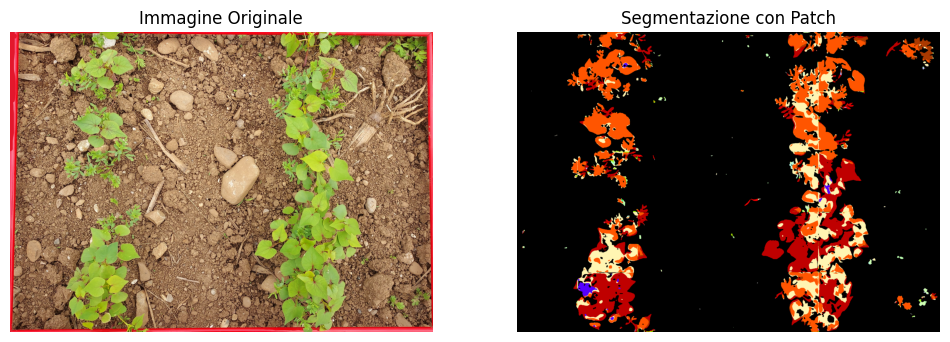

In [10]:
# --- Prediction con Patch ---
def predict_with_patches(image_path, patch_size):
    image = Image.open(image_path).convert("RGB")
    patches, positions, full_size = extract_patches(image, patch_size)

    patch_masks = []
    with torch.no_grad():
        for patch in patches:
            input_tensor = transform(patch).unsqueeze(0).to(device)
            output = model(input_tensor)
            mask = torch.argmax(output, dim=1).squeeze().cpu().numpy()
            mask = F.interpolate(torch.from_numpy(mask).unsqueeze(0).unsqueeze(0).float(),
                                 size=patch.size[::-1], mode='nearest').squeeze().numpy()
            patch_masks.append(mask.astype(np.int64))

    full_mask = reconstruct_mask(patch_masks, positions, full_size)
    color_mask = decode_segmap(full_mask)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Immagine Originale")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(color_mask)
    plt.title("Segmentazione con Patch")
    plt.axis("off")
    plt.show()

    """
    save_path = os.path.join(output_folder, "WE3DS_Weighted_CrossEntropyLoss.png")
    Image.fromarray(color_mask).save(save_path)
    print(f"Maschera salvata in: {save_path}")
    """

# --- Esegui ---
image_path = "../images/output_2_B/clean_image.png"
predict_with_patches(image_path, patch_size=448)
# 448 = 40 patches 
# 576 = 24 patches
# 960 = 12 patches
# 1140 = 6 patch
# 1636 = 4 patch
# 2236 = 2 patch